#Problem Synopsis:
In this notebook, we will examine how to develop a neural network model to predict the presence of a heart disease using patients' biomarkers.




### The dataset

The dataset has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not.

Feature description (copied from [here](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)):

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

# Library Imports


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Set random seed for reproducibility and control
keras.utils.set_random_seed(42)

# Read the data

In [ ]:
# dataset is standard and available throguh an online repository
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

#Examining the Data

In [ ]:
#Examine the the number of rows and columns in the dataset
df.shape

(303, 14)

The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable):

In [ ]:
# High level summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [ ]:
#Examining the first 10 rows of the dataset
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,normal,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,normal,1
7,57,0,4,120,354,0,0,163,1,0.6,1,0,normal,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,reversible,1
9,53,1,4,140,203,1,2,155,1,3.1,3,0,reversible,0


# Data Preprocessing


In [ ]:
#Determine numerical and categorical varaibles

categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']

In [ ]:
#Get dummies for categorical variables
df = pd.get_dummies(df, columns = categorical_variables, dtype='int64')

In [ ]:
#Exmaine new dataframe with dummy categoricals
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,67,160,286,108,1.5,2,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,67,120,229,129,2.6,2,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,37,130,250,187,3.5,3,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41,130,204,172,1.4,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
#Examining the class distribution (i.e. What % of the data is in the positive class?)
df.target.value_counts(normalize=True)

,proportion
target,
0,0.726073
1,0.273927


In [ ]:
#Removing the dependant variable from the dataset
y = df.pop('target')

We will now split the data into training and testing sets BEFORE we normalize them to prevent data leakage. data leakage occurs when normalization is applied to the entire dataset before splitting, the calculated statistics will include information from the test set. This leaks information about the test set into the training process, contaminating the model and leading to overly optimistic performance estimates.bold text

In [ ]:
#Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

In [ ]:
# calculating the mean and standard deviation of every numeric variable in the training set.
means = X_train[numerics].mean()
sd = X_train[numerics].std()

In [ ]:
means

,0
age,54.698347
trestbps,131.954545
chol,248.921488
thalach,148.504132
oldpeak,1.078099
slope,1.582645


In [ ]:
# normalizing the train and test dataframes with the means and standard deviations.
X_train[numerics]= (X_train[numerics] - means)/sd
X_test[numerics]= (X_test[numerics] - means)/sd

In [ ]:
#Examine the normalized dataframes
X_train.head()

,age,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
180,2.146720,-0.682081,0.373261,-1.172451,-0.740863,-0.938703,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
99,-0.300109,1.143718,0.912372,1.257355,0.102849,0.672404,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
190,0.700867,0.116706,-0.277391,-0.149375,1.284047,0.672404,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
110,2.480378,-0.396800,1.023913,0.575304,-0.909606,-0.938703,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
116,-2.190840,-0.339744,0.614932,0.319535,-0.909606,-0.938703,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 180 to 294
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              242 non-null    float64
 1   trestbps         242 non-null    float64
 2   chol             242 non-null    float64
 3   thalach          242 non-null    float64
 4   oldpeak          242 non-null    float64
 5   slope            242 non-null    float64
 6   sex_0            242 non-null    int64  
 7   sex_1            242 non-null    int64  
 8   cp_0             242 non-null    int64  
 9   cp_1             242 non-null    int64  
 10  cp_2             242 non-null    int64  
 11  cp_3             242 non-null    int64  
 12  cp_4             242 non-null    int64  
 13  fbs_0            242 non-null    int64  
 14  fbs_1            242 non-null    int64  
 15  restecg_0        242 non-null    int64  
 16  restecg_1        242 non-null    int64  
 17  restecg_2        24

The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [ ]:
# Converting the dataframes into Numpy arrays to easily feed the data into the nueral netowrk
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [ ]:
#Examine the shape the training data
X_train.shape, y_train.shape

((242, 29), (242,))

In [ ]:
#Examine the shape the test data
X_test.shape, y_test.shape


((61, 29), (61,))

In [ ]:
#examine the first row of the training array
X_train[0]

array([ 2.14671968, -0.68208146,  0.37326074, -1.17245071, -0.74086344,
       -0.93870273,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ])

# Build the NN model


In [ ]:
#Get the number of columns in the training data and make into the expected input shape for the Keras input layer:
num_columns = (X_train.shape[1],)

# define the input layer
input = keras.Input(shape=num_columns)

# feed the input vector to the hidden layer
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

In [ ]:
# Get and overview of the defined NN
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

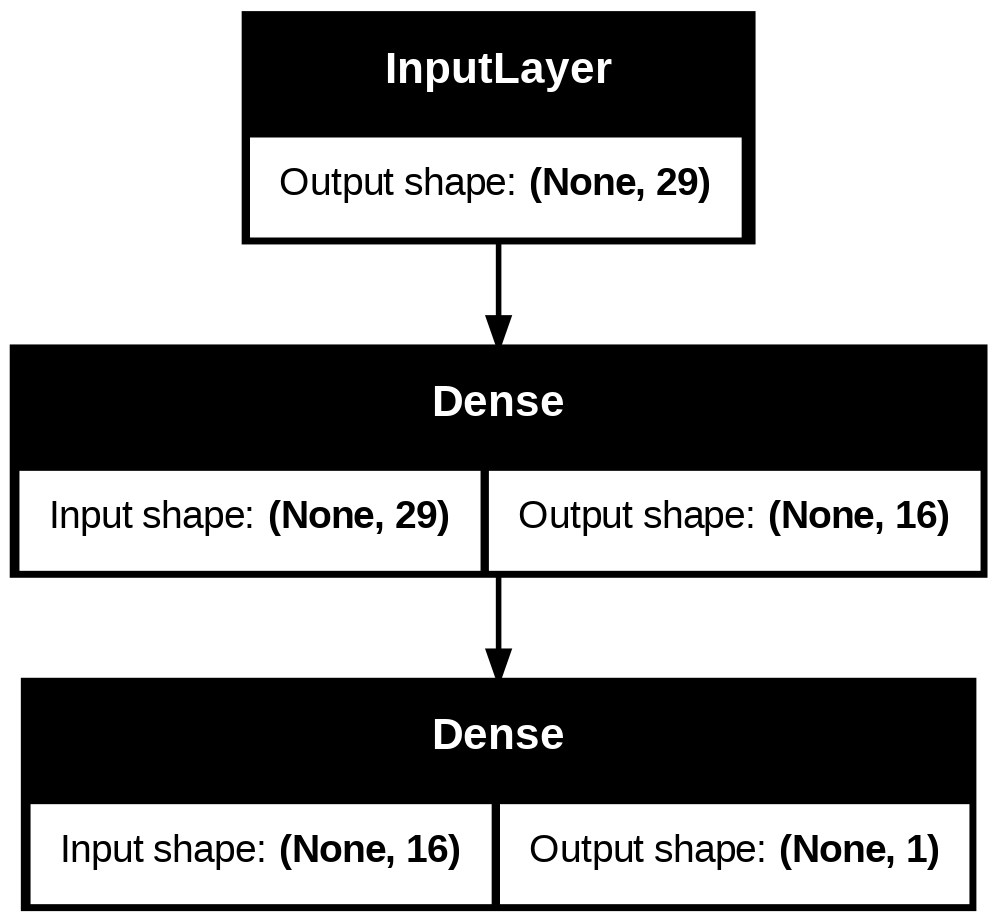

In [ ]:
#Vizualize the netork
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#Setting the optimiztion parameters for the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Training the model
history = model.fit(X_train,
                    y_train,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.5188 - loss: 0.7567 - val_accuracy: 0.6939 - val_loss: 0.6319
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5640 - loss: 0.7179 - val_accuracy: 0.7347 - val_loss: 0.6062
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5946 - loss: 0.6879 - val_accuracy: 0.7551 - val_loss: 0.5839
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6033 - loss: 0.6606 - val_accuracy: 0.7755 - val_loss: 0.5641
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6419 - loss: 0.6349 - val_accuracy: 0.7755 - val_loss: 0.5468
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6882 - loss: 0.6108 - val_accuracy: 0.7551 - val_loss: 0.5310
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7110 - loss: 0.5885 - val_accuracy: 0.7755 - val_loss: 0.5161
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7384 - loss: 0.5676 - val_accuracy: 0.7551 - val_loss

Let's plot the training and loss curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [ ]:
#Getting the model's performance data
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
# Evaluate the model's accuracy on the test set
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7845 - loss: 0.4506


[0.5284574627876282, 0.7704917788505554]

To assess if this accuracy number is an indicator of good performance, we can compare it to the accuracy of a simple baseline model where we predict 0 for every point. The accuracy will be 72.6% for that simple model since that is the percentge of 0 classes in the original dataframe. Therefore, an accuracy of 78.5% is an imporvement. However, we need to investigate the possiblity of overfitting.





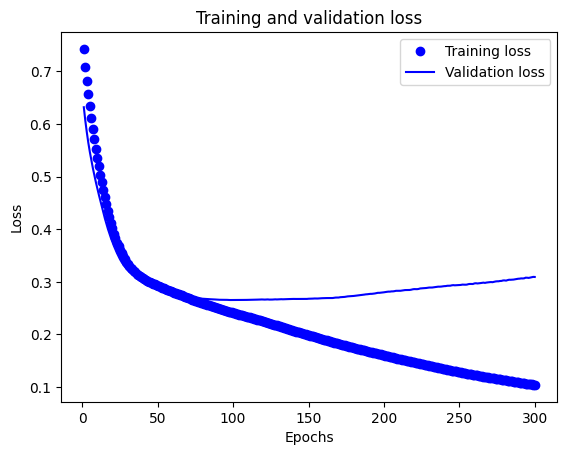

In [ ]:
#plotting loss for training and testing sets to check for overfitting

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

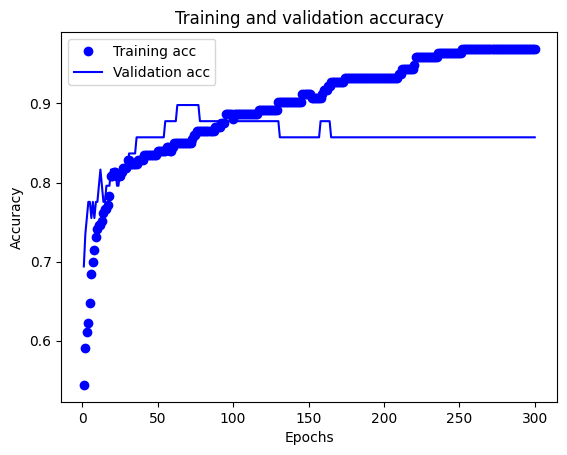

In [ ]:
#plotting accuracy for training and testing sets to check for overfitting
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Looking at both plots, we can see that the model starts to overfit around the 100th epoch. To fix that, we will create a new model and train it for 80 epochs and see how it performs


In [ ]:
# Training the second model on 80 epoch only to minimize overfititng
history1 = model.fit(X_train,
                    y_train,
                    epochs=80,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9876 - loss: 0.0564 - val_accuracy: 0.8367 - val_loss: 0.3625
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9876 - loss: 0.0561 - val_accuracy: 0.8367 - val_loss: 0.3634
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9876 - loss: 0.0559 - val_accuracy: 0.8367 - val_loss: 0.3630
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9876 - loss: 0.0556 - val_accuracy: 0.8367 - val_loss: 0.3627
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9876 - loss: 0.0554 - val_accuracy: 0.8367 - val_loss: 0.3638
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9876 - loss: 0.0552 - val_accuracy: 0.8367 - val_loss: 0.3643
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9876 - loss: 0.0550 - val_accuracy: 0.8367 - val_loss: 0.3646
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9876 - loss: 0.0548 - val_accuracy: 0.8367 - val_loss: 0.3657


In [ ]:
#Getting the model's performance data
history_dict = history1.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

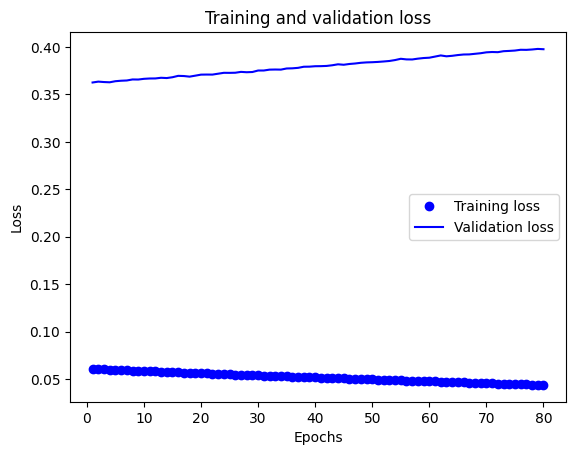

In [ ]:
#plotting loss for training and testing sets to check for overfitting

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

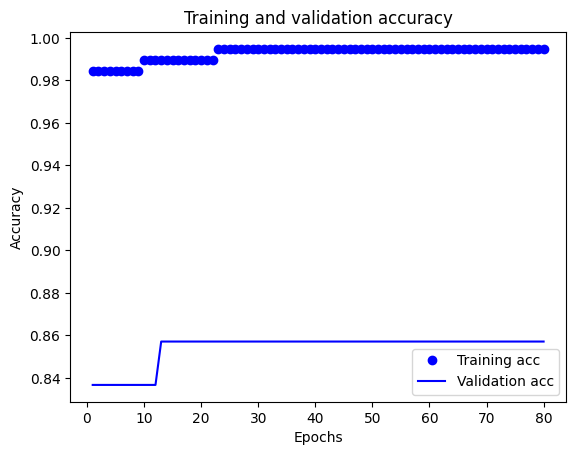

In [ ]:
#plotting accuracy for training and testing sets to check for overfitting
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model's accuracy on the test set
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8272 - loss: 0.6135


[0.7397826313972473, 0.8032786846160889]

Reducing the number of epochs definitely improved the model's perfornmance and reduced overfitting. In additon, an accuracy score of 82.7% of the test set is a good jump in performance compared to the base model's 72.6%.
<br>
<br>
<br>
<br>
Future improvements to the model include adding callbacks to control the learning rate, and add early stopping to prevent overfitting.